# 01-Data_Exploration

In [2]:
%%capture
# %pip install flwr[simulation] torch torchvision matplotlib sklearn openml

In [3]:
!pip install flwr[simulation] torch torchvision matplotlib scikit-learn openml

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.1 MB/s eta 0:00:

In [4]:
import os
import pandas as pd
import numpy as np
import flwr as fl
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.common import Metrics
from torch.utils.data import DataLoader, random_split

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("torch", torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

flwr 1.21.0
numpy 2.0.2
torch 2.8.0+cu126
Training on cpu


In [6]:
### THIS SECTION NEEDS TO BE SET TO DETERMINE WHICH CONFIGURATION METHOD TO UTILISE

SPLIT_AVAILABLE_METHODS = ['STRATIFIED','LEAVE_ONE_OUT', 'ONE_CLASS', 'HALF_BENIGN', 'DIRICHLET' ]
METHOD = 'DIRICHLET'
NUM_OF_STRATIFIED_CLIENTS = 10  # only applies to stratified method
NUM_OF_ROUNDS = 5              # Number of FL rounds


In [7]:
individual_classifier = True
group_classifier = False
binary_classifier = False


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load and combine all training data
import os
from tqdm import tqdm

# Define dataset directory (adjust path as needed)
DATASET_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/data/CICIoT2023/'

# Load all CSV files
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()

# Use 80% for training
training_sets = df_sets[:int(len(df_sets)*.8)]

print(f"Loading {len(training_sets)} training files...")

# First, let's check what columns are actually available in the dataset
sample_df = pd.read_csv(DATASET_DIRECTORY + training_sets[0])
print(f"Available columns in dataset: {list(sample_df.columns)}")
print(f"Dataset shape: {sample_df.shape}")

# Combine all training data with immediate rounding
combined_df = pd.DataFrame()
for file in tqdm(training_sets):
    df_temp = pd.read_csv(DATASET_DIRECTORY + file)

    # Round numbers immediately after loading each file
    print(f"Rounding numbers in {file}...")
    for col in df_temp.columns:
        if col != 'Label' and df_temp[col].dtype in ['float64', 'float32']:
            # Get max value to determine rounding precision
            col_max = df_temp[col].abs().max()

            if col_max > 1000:
                # Large values: round to 2 decimal places
                df_temp[col] = df_temp[col].round(2)
            elif col_max > 1:
                # Medium values: round to 4 decimal places
                df_temp[col] = df_temp[col].round(4)
            else:
                # Small values (0-1): round to 6 decimal places
                df_temp[col] = df_temp[col].round(6)

    combined_df = pd.concat([combined_df, df_temp], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print("All numbers have been rounded during loading process")

# Use actual column names from the dataset (excluding the Label column)
X_columns = [col for col in combined_df.columns if col != 'Label']
y_column = 'Label'

print(f"Using {len(X_columns)} feature columns")
print(f"Feature columns: {X_columns[:10]}...")  # Show first 10 columns

# Apply label mapping based on classification type
dict_34_classes = {
    'BENIGN': 0, 'DDOS-RSTFINFLOOD': 1, 'DDOS-PSHACK_FLOOD': 2, 'DDOS-SYN_FLOOD': 3,
    'DDOS-UDP_FLOOD': 4, 'DDOS-TCP_FLOOD': 5, 'DDOS-ICMP_FLOOD': 6, 'DDOS-SYNONYMOUSIP_FLOOD': 7,
    'DDOS-ACK_FRAGMENTATION': 8, 'DDOS-UDP_FRAGMENTATION': 9, 'DDOS-ICMP_FRAGMENTATION': 10,
    'DDOS-SLOWLORIS': 11, 'DDOS-HTTP_FLOOD': 12, 'DOS-UDP_FLOOD': 13, 'DOS-SYN_FLOOD': 14,
    'DOS-TCP_FLOOD': 15, 'DOS-HTTP_FLOOD': 16, 'MIRAI-GREETH_FLOOD': 17, 'MIRAI-GREIP_FLOOD': 18,
    'MIRAI-UDPPLAIN': 19, 'RECON-PINGSWEEP': 20, 'RECON-OSSCAN': 21, 'RECON-PORTSCAN': 22,
    'VULNERABILITYSCAN': 23, 'RECON-HOSTDISCOVERY': 24, 'DNS_SPOOFING': 25, 'MITM-ARPSPOOFING': 26,
    'BROWSERHIJACKING': 27, 'BACKDOOR_MALWARE': 28, 'XSS': 29, 'UPLOADING_ATTACK': 30,
    'SQLINJECTION': 31, 'COMMANDINJECTION': 32, 'DICTIONARYBRUTEFORCE': 33
}

dict_8_classes = {
    0: 0,  # Benign
    1:1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1,  # DDoS
    13: 7, 14: 7, 15: 7, 16: 7,  # DoS
    17: 2, 18: 2, 19: 2,  # Mirai
    20: 3, 21: 3, 22: 3, 23: 3, 24: 3,  # Reconnaissance
    25: 4, 26: 4,  # Spoofing
    27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 5,  # Web
    33: 6  # Brute Force
}

dict_2_classes = {
    0: 0,  # Benign
    1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1, 16:1,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1,
    27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1  # All attacks as malicious
}

# Apply label mapping
combined_df['Label'] = combined_df['Label'].map(dict_34_classes)

if group_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_8_classes)
elif binary_classifier:
    combined_df['Label'] = combined_df['Label'].map(dict_2_classes)

# Remove rows with missing labels
combined_df = combined_df.dropna(subset=['Label'])
combined_df['Label'] = combined_df['Label'].astype(int)

print(f"Label distribution:\n{combined_df['Label'].value_counts().sort_index()}")


Loading 3 training files...
Available columns in dataset: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'Label']
Dataset shape: (712311, 40)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 33%|███▎      | 1/3 [00:03<00:07,  3.57s/it]

Rounding numbers in Merged01.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rounding numbers in Merged02.csv...


 67%|██████▋   | 2/3 [00:07<00:03,  3.66s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Rounding numbers in Merged03.csv...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 3/3 [00:11<00:00,  3.74s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzi

Combined dataset shape: (2158185, 40)
All numbers have been rounded during loading process
Using 39 feature columns
Feature columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number']...
Label distribution:
Label
0      50678
1     185891
2     188419
3     186790
4     247971
5     205674
6     329830
7     165555
8      13231
9      13060
10     20733
11      1052
12      1347
13    152300
14     92924
15    122589
16      3383
17     45719
18     34203
19     40798
20        95
21      4390
22      3777
23     17262
24      6290
25      8323
26     14162
27       263
28       133
29       206
30        63
31       234
32       237
33       603
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Training data

In [10]:
# Check to see if the file 'training_data.pkl' exists in the directory. If it does, load it. If not, print an error.
if os.path.isfile('training_data.pkl'):
    print("File exists, loading data...")
    train_df = pd.read_pickle('training_data.pkl')
    print("Training data loaded from pickle file.")

else:
    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Training sets: {}'.format(len(training_sets)))
    print('Test sets: {}'.format(len(test_sets)))

    # ######################
    # # TEMP CODE - This would replicate the original authors code with the last CSV
    # # for training data. Uncomment this section to use this code.
    # ######################
    # # Set training_sets to the last entry of training_sets
    # training_sets = training_sets[-33:]
    # print(f"TO REPLICATE ORIGINAL AUTHORS CODE WITH ONE FILE TRAIN - {training_sets}")
    # #####################
    # # END TEMP CODE
    # ######################

    # Concatenate all training sets into one dataframe
    dfs = []
    print("Reading training data...")
    for train_set in tqdm(training_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + train_set)
        dfs.append(df_new)
    train_df = pd.concat(dfs, ignore_index=True)

    # Complete training data set size
    print("Complete training data size: {}".format(train_df.shape))

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    train_df['Label'] = train_df['Label'].map(dict_34_classes)

    # The training data is the 80% of the CSV files in the dataset. The test data is the remaining 20%.
    # The Ray Federated learning mechanism cannot cope with all of the 80% training data, so we will split
    # the training data using test_train_split. The test data will be ignored as we will use all the data
    # from the train_sets files as our training data to keep parity with the original authors code.
    #
    # By using a subset of the training data split this way, we can have a randomised selection of data
    # from all the training CSV files, stratified by the attack types.

    # Percentage of original training data to use.
    TRAIN_SIZE = 0.99

    print(f"Splitting the data into {TRAIN_SIZE*100}%")

    X_train, X_test, y_train, y_test = train_test_split(train_df[X_columns], train_df[y_column], test_size= (1 - TRAIN_SIZE), random_state=42, stratify=train_df[y_column])

    # Recombine X_train, and y_train into a dataframe
    train_df = pd.concat([X_train, y_train], axis=1)

    # Clean up unused variables

    del X_train, y_train, X_test, y_test

    # Save the output to a pickle file
    print("Writing training data to pickle file...")
    train_df.to_pickle('training_data.pkl')

print("Training data size: {}".format(train_df.shape))

Training sets: 3
Test sets: 1
Reading training data...


 33%|███▎      | 1/3 [00:01<00:03,  1.76s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
 67%|██████▋   | 2/3 [00:03<00:01,  1.96s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 3/3 [00:05<00:00,  1.76s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent date

Complete training data size: (2158185, 40)
Splitting the data into 99.0%
Writing training data to pickle file...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training data size: (2136603, 40)


In [11]:
# show the unique values counts in the label column for train_df
print("Counts of attacks in train_df:")
print(train_df['Label'].value_counts())

Counts of attacks in train_df:
Label
6     326532
4     245491
5     203617
2     186535
3     184922
1     184032
7     163899
13    150777
15    121363
14     91995
0      50171
17     45262
19     40390
18     33861
10     20526
23     17089
26     14020
8      13099
9      12929
25      8240
24      6227
21      4346
22      3739
16      3349
12      1334
11      1042
33       597
27       260
32       235
31       232
29       204
28       132
20        94
30        62
Name: count, dtype: int64


In [12]:
train_df

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
1744454,20.00,6,64.00,5945.993762,0.00,0.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000168,100,0.000000,15
244901,7.92,17,65.91,43608.899979,0.00,0.0,0.0,0.00,0.00,0.0,...,6010,60,70,60.10,1.000000,60.10,0.000023,100,1.000000,4
1802064,20.00,6,64.00,16685.777937,1.00,0.0,1.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000060,100,0.000000,1
265185,20.00,6,64.00,37650.843806,0.00,0.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000027,100,0.000000,5
1024068,20.00,6,64.00,28273.029997,0.00,0.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000035,100,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095133,20.00,6,64.00,37820.595131,1.00,0.0,1.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000026,100,0.000000,1
2156929,20.00,6,64.00,39386.834445,0.00,1.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000025,100,0.000000,14
783592,8.00,17,64.00,46618.917417,0.00,0.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000021,100,0.000000,4
163885,20.00,6,64.00,16863.557414,0.00,1.0,0.0,0.00,0.00,0.0,...,6000,60,60,60.00,0.000000,60.00,0.000059,100,0.000000,7


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Test Data

In [13]:
# Check to see if the file 'test_data.pkl' exists in the directory. If it does, load it. If not, print an error.
testing_data_pickle_file = 'testing_data.pkl'

if os.path.isfile(testing_data_pickle_file):
    print(f"File {testing_data_pickle_file} exists, loading data...")
    test_df = pd.read_pickle(testing_data_pickle_file)
    print("Test data loaded from pickle file.")

else:
    print(f"File {testing_data_pickle_file} does not exist, constructing data...")

    df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
    df_sets.sort()
    training_sets = df_sets[:int(len(df_sets)*.8)]
    test_sets = df_sets[int(len(df_sets)*.8):]

    # Print the number of files in each set
    print('Test sets: {}'.format(len(test_sets)))

    # Concatenate all testing sets into one dataframe
    dfs = []
    print("Reading test data...")
    for test_set in tqdm(test_sets):
        df_new = pd.read_csv(DATASET_DIRECTORY + test_set)
        dfs.append(df_new)
    test_df = pd.concat(dfs, ignore_index=True)

    # Map y column to the dict_34_classes values - The pickle file already has this done.
    test_df['Label'] = test_df['Label'].map(dict_34_classes)

    # Save the output to a pickle file
    print(f"Writing test data to pickle file {testing_data_pickle_file}...")
    test_df.to_pickle(testing_data_pickle_file)

print("Testing data size: {}".format(test_df.shape))

File testing_data.pkl does not exist, constructing data...
Test sets: 1
Reading test data...


100%|██████████| 1/1 [00:06<00:00,  6.89s/it]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
100%|██████████| 1/1 [00:06<00:00,  6.89s/it]
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Writing test data to pickle file testing_data.pkl...
Testing data size: (676620, 40)


In [14]:
print("Number of rows in train_df: {}".format(len(train_df)))
print("Number of rows in test_df: {}".format(len(test_df)))

train_size = len(train_df)
test_size = len(test_df)

Number of rows in train_df: 2136603
Number of rows in test_df: 676620



# Scale the test and train data


Scale the training data input features

In [15]:
scaler = StandardScaler()

# Check for and handle infinite values
print("Checking for and handling infinite values...")
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed.")

train_df[X_columns] = scaler.fit_transform(train_df[X_columns])

Checking for and handling infinite values...
Infinite values handled and rows with NaN removed.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
# Check for and handle infinite values
print("Checking for and handling infinite values in test data...")
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.dropna(inplace=True)
print("Infinite values handled and rows with NaN removed from test data.")

# Fit the scaler on the training data and then transform the test data
#scaler.fit(train_df[X_columns])
test_df[X_columns] = scaler.transform(test_df[X_columns])

Checking for and handling infinite values in test data...
Infinite values handled and rows with NaN removed from test data.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
class_size_map = {2: "Binary", 8: "Group", 34: "Individual"}

if group_classifier:
    print("Group 8 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_7_classes values
    test_df['label'] = test_df['label'].map(dict_8_classes)
    train_df['label'] = train_df['label'].map(dict_8_classes)
    class_size = "8"

elif binary_classifier:
    print("Binary 2 Class Classifier... - Adjusting labels in test and train dataframes")
    # Map y column to the dict_2_classes values
    test_df['label'] = test_df['label'].map(dict_2_classes)
    train_df['label'] = train_df['label'].map(dict_2_classes)
    class_size = "2"

else:
    print ("Individual 34 Class classifier... - No adjustments to labels in test and train dataframes")
    class_size = "34"

Individual 34 Class classifier... - No adjustments to labels in test and train dataframes


# Split the Training Data into partitions for the Federated Learning clients depending on the test required

In [18]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the colours used for text printing
from enum import Enum
class Colours(Enum):
    RED = "\033[31m"
    YELLOW = "\033[33m"
    NORMAL = "\033[0m"

# Define fl_X_train and fl_y_train
fl_X_train = []
fl_y_train = []

client_df = pd.DataFrame()

# Define the target label column
y_column = 'Label'

# STRATIFIED method: evenly distribute class labels across clients
if METHOD == 'STRATIFIED':
    print(f"{Colours.YELLOW.value}STRATIFIED METHOD{Colours.NORMAL.value} with {class_size} class classifier")
    skf = StratifiedKFold(n_splits=NUM_OF_STRATIFIED_CLIENTS, shuffle=True, random_state=42)
    for _, test_index in skf.split(train_df[X_columns], train_df[y_column]):
        fl_X_train.append(train_df.iloc[test_index][X_columns])
        fl_y_train.append(train_df.iloc[test_index][y_column])

# LEAVE_ONE_OUT: remove one class (or benign) from each client’s dataset
elif METHOD == 'LEAVE_ONE_OUT':
    print(f"{Colours.YELLOW.value}LEAVE_ONE_OUT METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: exclude attack class 1
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Exclude one specific attack class
            client_df = current_fold_df[current_fold_df[y_column] != (i + 1)].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# ONE_CLASS: each client has Benign + 1 attack class only
elif METHOD == 'ONE_CLASS':
    print(f"{Colours.YELLOW.value}ONE_CLASS METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    num_splits = int(class_size) - 1 if (individual_classifier or group_classifier) else 10
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if binary_classifier:
            # Even-indexed client: only Benign data
            if i % 2 == 0:
                client_df = current_fold_df[current_fold_df[y_column] != 1].copy()
            else:
                client_df = current_fold_df.copy()
        else:
            # Include only Benign and the (i+1)-th attack class
            mask = (current_fold_df[y_column] == 0) | (current_fold_df[y_column] == (i + 1))
            client_df = current_fold_df[mask].copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# HALF_BENIGN: alternate clients between only-benign and full-class datasets
elif METHOD == 'HALF_BENIGN':
    print(f"{Colours.YELLOW.value}HALF_BENIGN METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    for i, (_, test_index) in enumerate(skf.split(train_df[X_columns], train_df[y_column])):
        current_fold_df = train_df.iloc[test_index]
        if i % 2 == 0:
            # Even-indexed clients: only Benign data
            client_df = current_fold_df[current_fold_df[y_column] == 0].copy()
        else:
            # Odd-indexed clients: all data
            client_df = current_fold_df.copy()

        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])
# DIRICHLET: phân phối dữ liệu theo phân phối Dirichlet (non-IID)
elif METHOD == 'DIRICHLET':
    print(f"{Colours.YELLOW.value}DIRICHLET METHOD{Colours.NORMAL.value} with {class_size} class classifier")

    # số client
    num_clients = NUM_OF_DIRICHLET_CLIENTS if 'NUM_OF_DIRICHLET_CLIENTS' in globals() else 10

    # hệ số alpha điều khiển mức độ non-IID
    # alpha nhỏ → dữ liệu mỗi client càng "nghiêng" về 1 số lớp
    alpha = DIRICHLET_ALPHA if 'DIRICHLET_ALPHA' in globals() else 0.5

    # lấy y
    y_data = train_df[y_column].values
    X_data = train_df[X_columns].values

    # phân chia chỉ số mẫu theo class
    class_indices = {}
    for cls in np.unique(y_data):
        class_indices[cls] = np.where(y_data == cls)[0]

    # tạo phân phối Dirichlet cho mỗi lớp
    client_indices = [[] for _ in range(num_clients)]
    for cls, indices in class_indices.items():
        # số mẫu của class này
        n_samples = len(indices)

        # phân phối theo Dirichlet
        proportions = np.random.dirichlet([alpha] * num_clients)

        # số mẫu cho mỗi client
        splits = (proportions * n_samples).astype(int)

        # để tránh mất mẫu do làm tròn
        while splits.sum() < n_samples:
            splits[np.argmax(proportions)] += 1
        while splits.sum() > n_samples:
            splits[np.argmax(splits)] -= 1

        # shuffle và chia dữ liệu
        np.random.shuffle(indices)
        start = 0
        for client_id, split_size in enumerate(splits):
            end = start + split_size
            client_indices[client_id].extend(indices[start:end])
            start = end

    # gom dữ liệu cho từng client
    for client_id in range(num_clients):
        idxs = client_indices[client_id]
        client_df = train_df.iloc[idxs]
        fl_X_train.append(client_df[X_columns])
        fl_y_train.append(client_df[y_column])

# Handle unknown METHOD value
else:
    print(f"{Colours.RED.value}ERROR: Method {METHOD} not recognised{Colours.NORMAL.value}")

# Update the number of clients created


DIRICHLET METHOD with 34 class classifier


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
# Model Poisoning Attack
print("--- Defining Model Poisoning Attack ---")
num_malicious_clients = 1  # about 10% of 33 clients
# Note: client_fn creates clients with string IDs, so we create a list of strings
malicious_client_ids = [str(i) for i in range(num_malicious_clients)]
poison_factor = 3.0 # Amplify weights to overpower other clients. A negative value could be used to flip the weights.

print(f"Poisoning {num_malicious_clients} clients: {malicious_client_ids}")
print(f"Scaling weights by a factor of {poison_factor} for malicious clients after local training.")
print("--- Model Poisoning Attack Defined ---")


--- Defining Model Poisoning Attack ---
Poisoning 1 clients: ['0']
Scaling weights by a factor of 3.0 for malicious clients after local training.
--- Model Poisoning Attack Defined ---


In [20]:
# Update the number of clients created
NUM_OF_CLIENTS = len(fl_X_train)
# --- Inspect the training data for each client ---
for i in range(NUM_OF_CLIENTS):
    print(f"\n--- Client ID: {i} ---")
    print(f"fl_X_train[{i}].shape: {fl_X_train[i].shape}")
    print(f"fl_y_train[{i}].value_counts():\n{fl_y_train[i].value_counts()}")
    print(f"fl_y_train[{i}].unique(): {fl_y_train[i].unique()}")

# Check if two clients have identical feature data
print(f"\nfl_X_train[0].equals(fl_X_train[1]): {fl_X_train[0].equals(fl_X_train[1])}")


--- Client ID: 0 ---
fl_X_train[0].shape: (183906, 39)
fl_y_train[0].value_counts():
Label
7     34432
6     33401
13    31946
2     28657
18    16045
15     8684
1      8371
23     6893
17     4805
9      2651
19     1855
26     1022
0       991
5       940
24      836
21      523
16      471
12      465
14      258
25      195
22      179
8        97
29       56
11       40
3        37
27       19
28       17
4         8
30        5
10        4
32        2
31        1
Name: count, dtype: int64
fl_y_train[0].unique(): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28 29 30 31 32]

--- Client ID: 1 ---
fl_X_train[1].shape: (185814, 39)
fl_y_train[1].value_counts():
Label
4     76023
6     35976
0     22555
1     12569
10     9395
13     6467
15     6137
5      3762
2      3469
24     2369
3      1887
9      1391
19      793
7       463
25      400
21      307
23      298
26      294
11      293
18      288
17      209
14      119
8        99
12     

Visualize Data Distribution

STRATIFIED Client

In [21]:
#STRATIFIED Client

In [22]:
#LEAVE_ONE_OUT

In [23]:
#Half begign

In [24]:
#One class

/tmp/ipython-input-3333892375.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors1 = plt.cm.get_cmap('tab20', 20)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


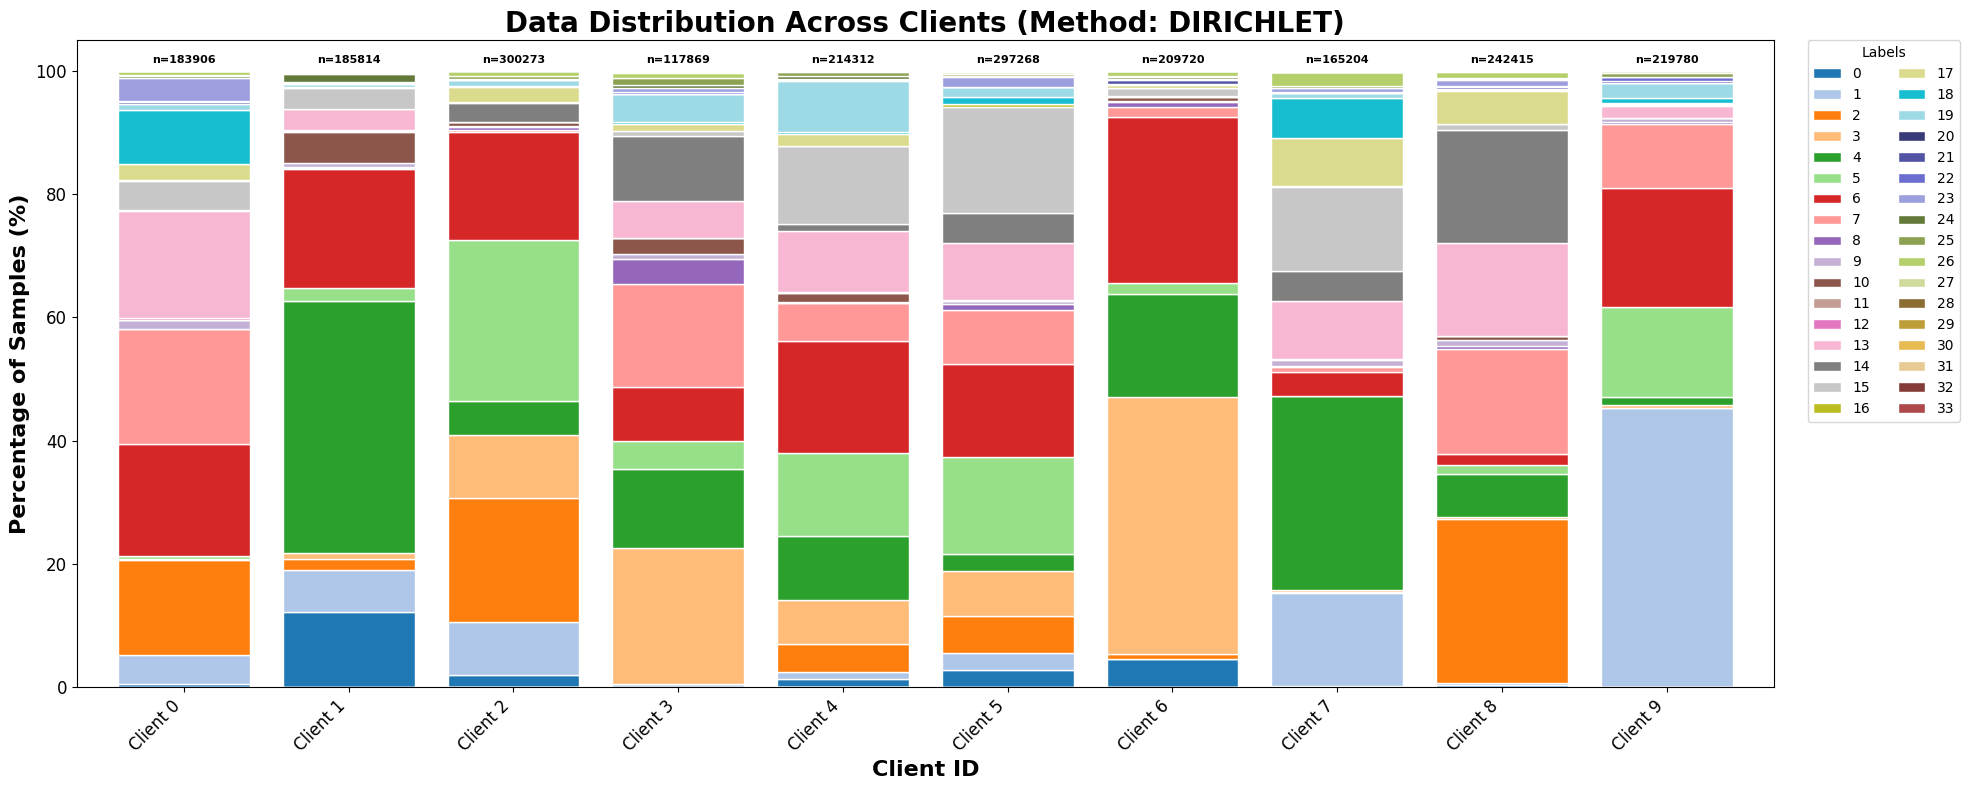

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
client_distributions = {}
for i in range(NUM_OF_CLIENTS):
    # .value_counts() returns a Series, convert it to a dictionary
    client_distributions[f'Client {i}'] = fl_y_train[i].value_counts().to_dict()

# 2. Convert the dictionary to a Pandas DataFrame for easy manipulation
df_dist = pd.DataFrame(client_distributions).fillna(0).astype(int)
df_dist = df_dist.sort_index() # Sort the labels numerically for consistent colors

# 3. Plot a Stacked Bar Chart
# Convert absolute counts to percentages for the chart y-axis
df_percent = df_dist.divide(df_dist.sum(axis=0), axis=1) * 100

# Create a diverse color palette to ensure distinct colors for all 34 labels
# We combine multiple colormaps to get enough unique colors
colors1 = plt.cm.get_cmap('tab20', 20)
colors2 = plt.cm.get_cmap('tab20b', 20)
colors = np.vstack((colors1.colors, colors2.colors))

# Plot the chart with a much wider figure size
ax = df_percent.T.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 8), # Increased width for readability
    color=colors,
    width=0.8,
    edgecolor="white"
)

# 4. Customize the plot for better presentation
plt.title(f'Data Distribution Across Clients (Method: {METHOD})', fontsize=20, fontweight='bold')
plt.xlabel('Client ID', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Samples (%)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for better fit
plt.yticks(fontsize=12)
plt.ylim(0, 105) # Add a little space at the top for annotations

# Move the legend outside the plot and arrange it in 2 columns
plt.legend(
    title='Labels',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize='medium',
    ncol=2 # Arrange legend in two columns
)

# Adjust layout to prevent the legend from being cut off
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add total sample count (n=...) above each bar for context
for i, total in enumerate(df_dist.sum(axis=0)):
    ax.text(i, 101, f'n={total}', ha='center', va='bottom', fontsize=8, fontweight='bold')

#  plt.show()

Prepare an output directory where we can store the results of the federated learning

In [26]:
# Create an "Output" directory if it doesnt exist already
if not os.path.exists("Output"):
    os.makedirs("Output")

sub_dir_name = f"train_size-{train_size}"

# if sub_dir_name does not exist, create it
if not os.path.exists(f"Output/{sub_dir_name}"):
    os.makedirs(f"Output/{sub_dir_name}")

test_directory_name = f"{METHOD}_Classifier-{class_size}_Clients-{NUM_OF_CLIENTS}"
output_path = f"Output/{sub_dir_name}/{test_directory_name}" # Lưu lại đường dẫn để dùng sau

# Create an "Output/{METHOD}-{NUM_OF_CLIENTS}-{NUM_OF_ROUNDS}" directory if it doesnt exist already
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Ensure the directory is empty
for file in os.listdir(output_path):
    file_path = os.path.join(output_path, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)

# Original training size is the sum of all the fl_X_train sizes
original_training_size = 0
for i in range(len(fl_X_train)):
    original_training_size += fl_X_train[i].shape[0]

# Write this same info to the output directory/Class Split Info.txt
with open(f"{output_path}/Class Split Info.txt", "w") as f:
    for i in range(len(fl_X_train)):
        f.write(f"Client ID: {i}\n")
        f.write(f"fl_X_train.shape: {fl_X_train[i].shape}\n")
        f.write(f"Training data used {original_training_size}\n")
        f.write(f"fl_y_train.value_counts():\n{fl_y_train[i].value_counts().to_string()}\n")
        f.write(f"fl_y_train.unique(): {fl_y_train[i].unique()}\n\n")

print(f"Output directory and summary file created at: {output_path}")

Output directory and summary file created at: Output/train_size-2136603/DIRICHLET_Classifier-34_Clients-10


Convert the training dataset


In [27]:
# Convert the testing dataframe to numpy arrays for TensorFlow/Keras
X_test = test_df[X_columns].to_numpy()
y_test = test_df[y_column].to_numpy()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [28]:
# Determine the number of unique classes in the target column
num_unique_classes = len(train_df[y_column].unique())

# Store the shapes of the original dataframes for logging purposes before deleting them
train_df_shape = train_df.shape
test_df_shape = test_df.shape

# Now that we have fl_X_train, fl_y_train, X_test, and y_test extracted,
# we can safely delete the large dataframes to free up memory
if 'train_df' in locals():
    del train_df
if 'test_df' in locals():
    del test_df
if 'client_df' in locals():
    del client_df
print("Final data conversion to numpy complete. Dataframes deleted to free up memory.")

Final data conversion to numpy complete. Dataframes deleted to free up memory.


Data check

In [29]:
print("NUM_CLIENTS:", NUM_OF_CLIENTS)

print("NUM_ROUNDS:", NUM_OF_ROUNDS)
print()


print("Original training size: {}".format(original_training_size))


print("Checking training data split groups")
for i in range(len(fl_X_train)):
    print(i, ":", "X Shape", fl_X_train[i].shape, "Y Shape", fl_y_train[i].shape)


# Print the sizes of X_test and y_test
print("\nChecking testing data")
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

print("\nDeploy Simulation")

NUM_CLIENTS: 10
NUM_ROUNDS: 5

Original training size: 2136561
Checking training data split groups
0 : X Shape (183906, 39) Y Shape (183906,)
1 : X Shape (185814, 39) Y Shape (185814,)
2 : X Shape (300273, 39) Y Shape (300273,)
3 : X Shape (117869, 39) Y Shape (117869,)
4 : X Shape (214312, 39) Y Shape (214312,)
5 : X Shape (297268, 39) Y Shape (297268,)
6 : X Shape (209720, 39) Y Shape (209720,)
7 : X Shape (165204, 39) Y Shape (165204,)
8 : X Shape (242415, 39) Y Shape (242415,)
9 : X Shape (219780, 39) Y Shape (219780,)

Checking testing data
X_test size: (676597, 39)
y_test size: (676597,)

Deploy Simulation


In [30]:
print("X_test min/max/mean:", np.min(X_test), np.max(X_test), np.mean(X_test))
print("Client 0 X min/max/mean:", np.min(fl_X_train[0]), np.max(fl_X_train[0]), np.mean(fl_X_train[0]))

X_test min/max/mean: -52.761867091401996 614.1144156191625 -0.0004547695913776816
Client 0 X min/max/mean: -52.761867091401996 614.1144156191625 0.010969211630893096


#Federated Learning

Import the libraries and print the versions


In [31]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


Define the Client and Server code

In [32]:
import os
import flwr as fl
import numpy as np
import tensorflow as tf

print('scikit-learn {}.'.format(sklearn.__version__))
print("flwr", fl.__version__)
print("numpy", np.__version__)
print("tf", tf.__version__)
# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

import datetime

client_evaluations = []

class NumpyFlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, train_data, train_labels):
        self.model = model
        self.cid = cid
        self.train_data = train_data
        self.train_labels = train_labels

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Training...")
        self.model.fit(self.train_data, self.train_labels, epochs=5, batch_size=32)
        print ("Client ", self.cid, "Training complete...")

        weights = self.model.get_weights()

        # If the client is in the malicious list, poison the weights
        if self.cid in malicious_client_ids:
            print(f"Client {self.cid} is malicious, applying model poisoning...")
            poisoned_weights = [w * poison_factor for w in weights]
            return poisoned_weights, len(self.train_data), {}

        return weights, len(self.train_data), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        print ("Client ", self.cid, "Evaluating...")
        loss, accuracy = self.model.evaluate(self.train_data, self.train_labels, batch_size=32)
        print(f"{Colours.YELLOW.value}Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}{Colours.NORMAL.value}")

        # Write the same message to the "Output/{cid}_Evaluation.txt" file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/{self.cid}_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - Client {self.cid} evaluation complete - Accuracy: {accuracy:.6f}, Loss: {loss:.6f}\n")

            # Close the file
            f.close()

        return loss, len(self.train_data), {"accuracy": accuracy}

    def predict(self, incoming):
        prediction = np.argmax( self.model.predict(incoming) ,axis=1)
        return prediction

def client_fn(cid: str) -> NumpyFlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    #model = tf.keras.applications.MobileNetV2((32, 32, 3), classes=10, weights=None)
    #model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

    print ("Client ID:", cid)

    model = Sequential([
      #Flatten(input_shape=(79,1)),
      Dense(50, activation='relu', input_shape=(fl_X_train[0].shape[1],)),
      Dense(25, activation='relu'),
      Dense(num_unique_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    partition_id = int(cid)
    X_train_c = fl_X_train[partition_id]
    y_train_c = fl_y_train[partition_id]

    # Create a  single Flower client representing a single organization
    return NumpyFlowerClient(cid, model, X_train_c, y_train_c)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
eval_count = 0

def get_evaluate_fn(server_model):
    global eval_count

    def evaluate(server_round, parameters, config):
        global eval_count

        # Update model weights from the latest client parameters
        server_model.set_weights(parameters)
        print(f"Server Evaluating... Evaluation Count: {eval_count}")

        # Evaluate the model on the test set
        loss, accuracy = server_model.evaluate(X_test, y_test)

        # Record accuracy and loss for visualization or tracking
        server_accuracy_history.append(accuracy)
        server_loss_history.append(loss)

        # Make predictions and save them to a file
        y_pred = server_model.predict(X_test)
        print("Prediction: ", y_pred, y_pred.shape)
        np.save("y_pred-" + str(eval_count) + ".npy", y_pred)

        # Print evaluation result to console
        print(f"{Colours.YELLOW.value}Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}{Colours.NORMAL.value}")

        # Write evaluation log to file
        with open(f"Output/{sub_dir_name}/{test_directory_name}/Server_Evaluation.txt", "a") as f:
            f.write(f"{datetime.datetime.now()} - {server_round} : Server evaluation complete - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}\n")

        # Increment evaluation counter
        eval_count += 1

        return loss, {"accuracy": accuracy}

    return evaluate



scikit-learn 1.6.1.
flwr 1.21.0
numpy 2.0.2
tf 2.19.0


Initialize Server Model and Strategy

In [33]:
from flwr.common import ndarrays_to_parameters
server_model = Sequential([
    #Flatten(input_shape=(79,1)),
    Flatten(input_shape=(fl_X_train[0].shape[1] , 1)),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(num_unique_classes, activation='softmax')
])


server_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

initial_weights = server_model.get_weights()
initial_parameters = ndarrays_to_parameters(initial_weights)
# Create FedAvg strategy
# strategy = fl.server.strategy.FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10, #10,
#         min_evaluate_clients=5, #5,
#         min_available_clients=10, #10,
#         evaluate_fn=get_evaluate_fn(server_model),
#         #evaluate_metrics_aggregation_fn=weighted_average,
# )
# Test FedAdam


strategy = fl.server.strategy.FedAdam(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_fn=get_evaluate_fn(server_model),
        eta=1.0,           # Server-side learning rate
        beta_1=0.9,
        beta_2=0.999,
        tau=1e-9,
        initial_parameters=initial_parameters
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Deploy Simulation

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Deploy simulation... Method = DIRICHLET - Individual (34) Classifier
Number of Clients = 10

Writing output to: train_size-2136603/DIRICHLET_Classifier-34_Clients-10



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-09-14 05:18:25,535	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3971734732.0, 'memory': 7943469467.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


Server Evaluating... Evaluation Count: 0
 4520/21144 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.0060 - loss: 3.6588

(pid=1983) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1983) E0000 00:00:1757827122.769605    1983 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1983) E0000 00:00:1757827122.779186    1983 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=1983) W0000 00:00:1757827122.806654    1983 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=1983) W0000 00:00:1757827122.806718    1983 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=1983) W0000 00:00:1757827122.806722    1983 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking t

21144/21144 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.0064 - loss: 3.6560
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 16s 751us/step


INFO :      initial parameters (loss, other metrics): 3.6543502807617188, {'accuracy': 0.006578509695827961}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Prediction:  [[0.02114568 0.03403427 0.0252815  ... 0.03993218 0.0240844  0.02884529]
 [0.01363968 0.0436124  0.01431497 ... 0.03963369 0.02426514 0.03727224]
 [0.01244689 0.0305112  0.01303393 ... 0.02653438 0.02448392 0.03676306]
 ...
 [0.01291073 0.03356383 0.01676644 ... 0.04217883 0.01295356 0.02253583]
 [0.02050329 0.02882352 0.01740962 ... 0.04578459 0.01228229 0.01852711]
 [0.04414992 0.06187635 0.00747451 ... 0.04706392 0.02434495 0.02132011]] (676597, 34)
Server evaluation complete - Accuracy: 0.0066, Loss: 3.6544
(ClientAppActor pid=1984) Client ID: 3
(ClientAppActor pid=1984) Client  3 Training...


(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(pid=1984) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1984) E0000 0

(ClientAppActor pid=1984) Epoch 1/5


(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         


  26/3684 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0558 - loss: 3.4931        
  81/3684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.2257 - loss: 3.1272
 139/3684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3199 - loss: 2.7667
 197/3684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3701 - loss: 2.5000
 261/3684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4081 - loss: 2.2818
 317/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4330 - loss: 2.1356
 369/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4510 - loss: 2.0253
  84/9384 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.3631 - loss: 2.9288
 412/3684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4632 - loss: 1.9484
 130/9384 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.4602 - loss: 2.5594
 470/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4769 - loss: 1.8598
 185/9384 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.5398 - loss: 2.2176
 528/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4884 - l

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1984)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1984) Epoch 1/5
   1/9384 ━━━━━━━━━━━━━━━━━━━━ 5:02 32ms/step - accuracy: 0.9688 - loss: 0.1349
  58/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9472 - loss: 0.1412
 118/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9493 - loss: 0.1357
 177/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9506 - loss: 0.1328
  33/9290 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.1211 - loss: 3.5118       
 231/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9512 - loss: 0.1310
8747/9384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9544 - loss: 0.1246 [repeated 5x across cluster]
1414/9290 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5794 - loss: 1.2181
9384/9384 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9545 - loss: 0.1245 [repeated 13x across cluster]
2142/9384 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9541 - loss: 0.1221
(ClientAppActor pid=1983) Epoch 3/5
2555/9290 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6228 - loss: 0.9990 [re

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1983) Epoch 1/5
9290/9290 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.7323 - loss: 0.5251
   1/9290 ━━━━━━━━━━━━━━━━━━━━ 5:04 33ms/step - accuracy: 0.6250 - loss: 0.6065
  26/9290 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.7098 - loss: 0.5534
9279/9290 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7323 - loss: 0.5251 [repeated 69x across cluster]
  21/5163 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.1171 - loss: 3.3161   
 344/9290 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7312 - loss: 0.5155
 352/9290 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.7312 - loss: 0.5154
 374/9290 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.7314 - loss: 0.5153 [repeated 11x across cluster]
8505/9290 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7323 - loss: 0.5252
1299/5163 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7313 - loss: 0.9745
1498/9290 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.7338 - loss: 0.5186
1525/9290 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step 

(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1984) Epoch 1/5
9290/9290 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.7325 - loss: 0.5193 [repeated 11x across cluster]
   1/7576 ━━━━━━━━━━━━━━━━━━━━ 2:27:37 1s/step - accuracy: 0.0000e+00 - loss: 3.8170
  53/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.0794 - loss: 3.4086
 108/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.2253 - loss: 3.0010
 164/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.3128 - loss: 2.6353
 224/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.3754 - loss: 2.3499
 269/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4108 - loss: 2.1858
 328/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4467 - loss: 2.0153
 383/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4735 - loss: 1.8880
 442/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4974 - loss: 1.7756
 502/7576 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5175 - loss: 1.6809
5023/5163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9009 - loss:

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

5163/5163 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9013 - loss: 0.2584 [repeated 6x across cluster]
  19/6698 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.0448 - loss: 3.5333       
  77/6698 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.2141 - loss: 3.2138
 136/6698 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.3160 - loss: 2.8407
 194/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.3804 - loss: 2.5321
 253/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.4265 - loss: 2.2909
 313/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.4610 - loss: 2.1013
 369/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.4858 - loss: 1.9610
 427/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5064 - loss: 1.8423
 478/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5216 - loss: 1.7546
 540/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5371 - loss: 1.6638
 594/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5486 - loss: 1.5961
1688/6698 ━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  28/5807 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.0509 - loss: 3.5747       
  80/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.2877 - loss: 3.1000
 137/5807 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4326 - loss: 2.6393
 189/5807 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5081 - loss: 2.3350
 238/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5573 - loss: 2.1197
 274/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5854 - loss: 1.9928
 322/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6157 - loss: 1.8521
 365/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6380 - loss: 1.7465
 401/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6539 - loss: 1.6696
 426/5807 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6637 - loss: 1.6215
 455/5807 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6741 - loss: 1.5703
 482/5807 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6830 - loss: 1.5265
 515/5807 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

1712/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8255 - loss: 0.7957
(ClientAppActor pid=1983) Client  0 Training...
1765/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8278 - loss: 0.7835
(ClientAppActor pid=1983) Epoch 1/5
1823/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8302 - loss: 0.7708
1881/5807 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8325 - loss: 0.7587
1952/5807 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8352 - loss: 0.7447
2016/5807 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8375 - loss: 0.7327
2084/5807 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8397 - loss: 0.7207
   1/5748 ━━━━━━━━━━━━━━━━━━━━ 2:34:11 2s/step - accuracy: 0.0000e+00 - loss: 3.7249
  46/5748 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.0758 - loss: 3.4150
2955/5807 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8608 - loss: 0.6083 [repeated 40x across cluster]
 710/5748 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7319 - loss: 1.2883
1084/5748 ━━━━━━━━━━━━━

(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1984) Epoch 1/5
   1/6554 ━━━━━━━━━━━━━━━━━━━━ 2:06:05 1s/step - accuracy: 0.0000e+00 - loss: 3.8568
  54/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.2860 - loss: 3.2566
 109/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4831 - loss: 2.7284
 158/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5713 - loss: 2.3646
 217/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6358 - loss: 2.0532
 272/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6763 - loss: 1.8424
 322/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7040 - loss: 1.6932
 371/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7254 - loss: 1.5745
 426/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7449 - loss: 1.4646
 485/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7618 - loss: 1.3670
 549/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7768 - loss: 1.2793
 606/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7880 - loss: 1.2129
 658/6554 ━━━━━━━━━━━

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1983) Epoch 1/5
   1/6869 ━━━━━━━━━━━━━━━━━━━━ 2:08:05 1s/step - accuracy: 0.0000e+00 - loss: 3.1810
  59/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5002 - loss: 2.5955
 117/6869 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6298 - loss: 2.1150
 175/6869 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6938 - loss: 1.7875
 222/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7274 - loss: 1.5982
 276/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7554 - loss: 1.4331
 333/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7777 - loss: 1.2989
 381/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7927 - loss: 1.2083
 425/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8042 - loss: 1.1380
 475/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8154 - loss: 1.0697
 527/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8252 - loss: 1.0089
 573/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8327 - loss: 0.9621
 624/6869 ━━━━━━━━━━━

INFO :      aggregate_fit: received 10 results and 0 failures


Server Evaluating... Evaluation Count: 1
6869/6869 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9723 - loss: 0.0798 [repeated 2x across cluster]
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - accuracy: 0.6183 - loss: 23.1399
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 17s 790us/step


INFO :      fit progress: (1, 23.09653091430664, {'accuracy': 0.6191100478172302}, 415.66507036200005)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.4010075e-38 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 4.9190972e-35 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]] (676597, 34)
Server evaluation complete - Accuracy: 0.6191, Loss: 23.0965
(ClientAppActor pid=1983) Client ID: 4
(ClientAppActor pid=1983) Client  4 Evaluating...
(ClientAppActor pid=1983) Client  9 Training complete...
6832/6869 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9723 - loss: 0.0798 [repeated 29x across cluster]


(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/6698 ━━━━━━━━━━━━━━━━━━━━ 39:44 356ms/step - accuracy: 0.0000e+00 - loss: 119.1357
  74/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.0000e+00 - loss: 98.2309 
 149/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.1135 - loss: 87.2289
 222/6698 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.2537 - loss: 73.4804
  57/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.0000e+00 - loss: 104.5084
 301/6698 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.3641 - loss: 62.6402
 115/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.0000e+00 - loss: 102.9122
 376/6698 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.4407 - loss: 55.1125
 164/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.0000e+00 - loss: 102.3083
 441/6698 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.4924 - loss: 50.0347
 221/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.0000e+00 - loss: 101.8957
 511/6698 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.5327 - loss: 45.8147
 295/9290 ━━━━━━━━━━━━━━━

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1983)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

  37/5748 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.0160 - loss: 90.5566          
6784/9290 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6238 - loss: 26.9627
1503/5748 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8968 - loss: 9.5982
1571/5748 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9003 - loss: 9.2791
8265/9290 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6408 - loss: 24.5343
1639/5748 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9035 - loss: 8.9829
1703/5748 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9063 - loss: 8.7228
1766/5748 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9088 - loss: 8.4826
1820/5748 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9109 - loss: 8.2882
1881/5748 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9132 - loss: 8.0800
8657/9290 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6407 - loss: 24.0667 [repeated 80x across cluster]
1945/5748 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9154 - loss: 7.8737
2013/5748 ━━━━━━━━━━━━━━━━━━━━ 5

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1984) Client 5 evaluation complete - Accuracy: 0.597336, Loss: 19.880417
2838/5748 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9344 - loss: 5.8893
2908/5748 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9351 - loss: 5.7821
2971/5748 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9356 - loss: 5.6897
(ClientAppActor pid=1984) Client ID: 8
(ClientAppActor pid=1984) Client  8 Evaluating...
   1/7576 ━━━━━━━━━━━━━━━━━━━━ 40:07 318ms/step - accuracy: 0.0000e+00 - loss: 120.3787
3029/5748 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9361 - loss: 5.6079
  60/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.3134 - loss: 73.4202 
3089/5748 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9365 - loss: 5.5264
  98/7576 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.4813 - loss: 55.2172
3122/5748 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9367 - loss: 5.4828
 135/7576 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.5765 - loss: 44.9774
3155/5748 ━━━━━━━━━━━━━━━━━━━━

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1983)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

   1/5807 ━━━━━━━━━━━━━━━━━━━━ 31:55 330ms/step - accuracy: 0.0000e+00 - loss: 166.1022
  65/5807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.0000e+00 - loss: 111.6041
 128/5807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.0000e+00 - loss: 106.8083
 187/5807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.0000e+00 - loss: 105.3412
 292/5807 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0000e+00 - loss: 104.3127
 358/5807 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0000e+00 - loss: 103.8343
 430/5807 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0000e+00 - loss: 103.4623
 494/5807 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0000e+00 - loss: 103.1985
 567/5807 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0000e+00 - loss: 102.9572
 632/5807 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0000e+00 - loss: 102.7995
4136/7576 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8858 - loss: 8.6914 [repeated 24x across cluster]
 687/5807 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1983) Client ID: 5
(ClientAppActor pid=1983) Client  5 Training...
2763/5807 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1943 - loss: 75.0433


(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1983) Epoch 1/5


(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   1/9290 ━━━━━━━━━━━━━━━━━━━━ 4:00:44 2s/step - accuracy: 0.6562 - loss: 11.2331
  56/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6093 - loss: 15.6936
 113/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6107 - loss: 14.4727
 170/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6122 - loss: 13.3656
 228/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6147 - loss: 12.3762
(ClientAppActor pid=1983) Client 1 evaluation complete - Accuracy: 0.387780, Loss: 47.231918
 478/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6248 - loss: 9.7536
 506/7576 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7334 - loss: 6.9011 [repeated 22x across cluster]
(ClientAppActor pid=1984) Client ID: 8
(ClientAppActor pid=1984) Client  8 Training...
1631/7576 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7457 - loss: 4.2451
(ClientAppActor pid=1984) Epoch 1/5
2075/7576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7486 - loss: 3.7899
2130/7576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - 

(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

7123/7576 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7963 - loss: 0.4053 [repeated 12x across cluster]
1007/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7236 - loss: 0.5429
1056/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7237 - loss: 0.5426
1103/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7238 - loss: 0.5424
1152/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7238 - loss: 0.5422
1206/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7239 - loss: 0.5419
1257/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7240 - loss: 0.5417
1316/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7240 - loss: 0.5416
1367/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7241 - loss: 0.5414
1417/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7242 - loss: 0.5413
1465/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7242 - loss: 0.5412
1520/9290 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7243 - loss: 0.5411
  60/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

1094/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7416 - loss: 0.5417
9145/9290 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7281 - loss: 0.5362 [repeated 2x across cluster]
1141/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7415 - loss: 0.5413
1190/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7414 - loss: 0.5409
1251/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7413 - loss: 0.5404
1315/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7413 - loss: 0.5398
1374/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7413 - loss: 0.5393
1428/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7412 - loss: 0.5390
1481/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7411 - loss: 0.5387
  29/5807 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.3957 - loss: 41.5013   
  71/5807 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4149 - loss: 34.9978
 134/5807 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4924 - loss: 27.8435
 193/5807 ━━━━━━━━━━━━━━━━━━━━ 

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1984) Epoch 1/5
2546/5807 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9331 - loss: 0.2171 [repeated 4x across cluster]
3061/5807 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9332 - loss: 0.2165
3127/5807 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9332 - loss: 0.2164
   1/9384 ━━━━━━━━━━━━━━━━━━━━ 5:43:40 2s/step - accuracy: 0.7500 - loss: 8.7339
  30/9384 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7715 - loss: 12.9328
  67/9384 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.7843 - loss: 11.2083
  98/9384 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.7927 - loss: 10.2917
 120/9384 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.7997 - loss: 9.8135 
3602/5807 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9332 - loss: 0.2162
 211/9384 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - accuracy: 0.8233 - loss: 8.1944 [repeated 3x across cluster]
3727/5807 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9332 - loss: 0.2162
3771/5807 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - a

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1983) Epoch 1/5
2709/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9105 - loss: 2.3913 [repeated 47x across cluster]
   1/6869 ━━━━━━━━━━━━━━━━━━━━ 2:19:30 1s/step - accuracy: 0.8438 - loss: 11.3469
3192/9384 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9141 - loss: 2.1773
  55/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9183 - loss: 7.1466
3278/9384 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9146 - loss: 2.1443
3307/9384 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9148 - loss: 2.1334
3393/9384 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9153 - loss: 2.1022
 511/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9401 - loss: 4.1385
5807/5807 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9332 - loss: 0.2155 [repeated 21x across cluster]
5633/5807 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9332 - loss: 0.2155
1769/6869 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9489 - loss: 2.4604
1844/6869 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step -

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1983) Epoch 1/5
  27/9384 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9563 - loss: 0.1207   
  84/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9553 - loss: 0.1201
 142/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9539 - loss: 0.1231
 199/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9537 - loss: 0.1238
 254/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9538 - loss: 0.1241
 267/9384 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9539 - loss: 0.1243
 310/9384 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9540 - loss: 0.1246
 367/9384 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9540 - loss: 0.1251
 428/9384 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9539 - loss: 0.1254
 489/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9538 - loss: 0.1257
   1/5163 ━━━━━━━━━━━━━━━━━━━━ 1:58:18 1s/step - accuracy: 0.3125 - loss: 57.2546
 535/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9536 - loss: 0.1259
  55/5163 ━━━━━━━━━━━

(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1984) Epoch 1/5
  33/5748 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7688 - loss: 20.8753    
4613/5163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8850 - loss: 0.3839 [repeated 73x across cluster]
 244/5748 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8348 - loss: 12.4844
 299/5748 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8419 - loss: 11.6177
3746/5163 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8844 - loss: 0.3868 [repeated 4x across cluster]
 356/5748 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8477 - loss: 10.8828
 407/5748 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8521 - loss: 10.3169
 459/5748 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8560 - loss: 9.8108 
4810/5163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8852 - loss: 0.3832 [repeated 2x across cluster]
1131/5748 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8858 - loss: 6.3621 [repeated 39x across cluster]
1158/5748 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.88

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1983) Epoch 1/5
   1/5748 ━━━━━━━━━━━━━━━━━━━━ 3:03 32ms/step - accuracy: 1.0000 - loss: 0.0117
  60/5748 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9741 - loss: 0.0993 
  32/3684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4294 - loss: 30.8834    
  94/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4520 - loss: 24.3810
5163/5163 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8967 - loss: 0.2858 [repeated 3x across cluster]
 157/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4756 - loss: 20.5884
 217/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4913 - loss: 18.2685
 275/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5017 - loss: 16.6826
 318/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5080 - loss: 15.7320
 586/5748 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9685 - loss: 0.1183
 373/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5153 - loss: 14.7055
 427/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5215 - loss: 13

(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  41/3684 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6881 - loss: 0.6843
5063/5748 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9689 - loss: 0.1190
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6470 - loss: 0.7540 [repeated 3x across cluster]
  29/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.3284 - loss: 34.1126   
 736/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6633 - loss: 0.7157
  67/6554 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.3500 - loss: 28.2586
 123/6554 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4399 - loss: 22.6749
 174/6554 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5026 - loss: 19.5686
 232/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5541 - loss: 17.1912
 277/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5851 - loss: 15.7910
 338/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6185 - loss: 14.3012
 393/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6427 - loss: 13.2475
 480/6554 ━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 10 results and 0 failures


Server Evaluating... Evaluation Count: 2
(ClientAppActor pid=1984) Client  6 Training complete...
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.5797 - loss: 5.7980
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 17s 786us/step


INFO :      fit progress: (2, 5.795658111572266, {'accuracy': 0.5793285965919495}, 903.5825291680001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.04449906 0.01214072 0.06128225 ... 0.01234574 0.0124288  0.01227947]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]] (676597, 34)
Server evaluation complete - Accuracy: 0.5793, Loss: 5.7957
(ClientAppActor pid=1984) Client ID: 7
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9495 - loss: 0.1748 [repeated 22x across cluster]
(ClientAppActor pid=1984) Client  7 Evaluating...


(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  35/5163 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.5376 - loss: 9.8466          
 109/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.0000e+00 - loss: 20.3340
 188/9290 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.0000e+00 - loss: 20.3324
 244/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 2.1015e-05 - loss: 20.3941
 301/9290 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.0117 - loss: 20.2356
 512/5163 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9361 - loss: 1.3688
 367/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.0510 - loss: 19.4835
 434/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.0984 - loss: 18.5412
 504/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.1475 - loss: 17.5538
 572/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.1921 - loss: 16.6543
 642/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.2339 - loss: 15.8047
 710/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.2708 - loss: 15.0535
 810/9290 ━━━━━━━━━━━━━━━━━━━━ 13s

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

   1/7576 ━━━━━━━━━━━━━━━━━━━━ 42:42 338ms/step - accuracy: 0.0000e+00 - loss: 19.7105
  68/7576 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.3588 - loss: 12.9491
 134/7576 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5756 - loss: 8.6093 
5914/9290 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4157 - loss: 6.9082
 652/7576 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8636 - loss: 2.7888 [repeated 2x across cluster]
5043/9290 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.4096 - loss: 7.3139
1349/7576 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9222 - loss: 1.5961 [repeated 18x across cluster]
 735/7576 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8755 - loss: 2.5467
7377/9290 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4325 - loss: 6.3487
2438/7576 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9417 - loss: 1.2255 [repeated 60x across cluster]
2615/7576 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9357 - loss: 1.3838
9290/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - a

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  26/6869 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9434 - loss: 1.2104    
 209/6869 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9878 - loss: 0.3012 [repeated 10x across cluster]
 338/6869 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9912 - loss: 0.2298
4447/7576 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8432 - loss: 2.4655
4892/7576 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8259 - loss: 2.5885 [repeated 62x across cluster]
9049/9290 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4606 - loss: 5.8242
2780/6869 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9972 - loss: 0.0968
2885/6869 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9972 - loss: 0.0963
2054/6869 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9968 - loss: 0.1025  [repeated 35x across cluster]
(ClientAppActor pid=1984) Client 8 evaluation complete - Accuracy: 0.678044, Loss: 5.239316
(ClientAppActor pid=1984) Client ID: 2
(ClientAppActor pid=1984) Client  2 Evaluating...


(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

4209/6869 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9627 - loss: 0.3650 [repeated 72x across cluster]
4367/6869 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9550 - loss: 0.4117
  39/9384 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.0000e+00 - loss: 20.8300      
  93/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 1.8467e-05 - loss: 20.8559
 166/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 1.1897e-04 - loss: 20.9319
 231/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.0349 - loss: 20.2398
 297/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.1030 - loss: 18.8288
 361/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.1685 - loss: 17.4638
 420/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.2229 - loss: 16.3272
 480/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.2718 - loss: 15.3051
 528/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.3067 - loss: 14.5749
 590/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.3469 - loss: 13.7328
 652/938

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1984) Client 2 evaluation complete - Accuracy: 0.526148, Loss: 4.895319
(ClientAppActor pid=1984) Client ID: 4
(ClientAppActor pid=1984) Client  4 Training...


(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1984) Epoch 1/5


(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


  30/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6267 - loss: 3.6635   
 259/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6697 - loss: 2.0646 [repeated 4x across cluster]
 343/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6721 - loss: 1.9148
  80/5748 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8244 - loss: 2.5291 [repeated 14x across cluster]
(ClientAppActor pid=1983) Client ID: 0
(ClientAppActor pid=1983) Client  0 Training...
(ClientAppActor pid=1983) Epoch 1/5
1491/5748 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9157 - loss: 1.0205
1653/5748 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9180 - loss: 0.9755
  33/5748 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7740 - loss: 3.1964    
2131/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6942 - loss: 1.1115 [repeated 92x across cluster]
1575/5748 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9169 - loss: 0.9964 [repeated 4x across cluster]
2753/5748 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accura

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1983)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

(ClientAppActor pid=1983) Epoch 1/5
4323/6698 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7450 - loss: 0.4746
  28/3684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4169 - loss: 5.2256     
5826/6698 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7451 - loss: 0.4744 [repeated 69x across cluster]
 493/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5643 - loss: 2.3021
6347/6698 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7451 - loss: 0.4744
6698/6698 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7452 - loss: 0.4743


(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         


(ClientAppActor pid=1984) Client  4 Training complete...
(ClientAppActor pid=1984) Client ID: 9
(ClientAppActor pid=1984) Client  9 Training...
(ClientAppActor pid=1984) Epoch 1/5
2293/3684 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6056 - loss: 1.4783 [repeated 64x across cluster]
   1/6869 ━━━━━━━━━━━━━━━━━━━━ 7:23:32 4s/step - accuracy: 0.7500 - loss: 1.1753
  53/6869 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7972 - loss: 1.3524
 109/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8458 - loss: 1.1234
2860/3684 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6096 - loss: 1.3960
 160/6869 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8686 - loss: 0.9972
 213/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8830 - loss: 0.9201
 256/6869 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8911 - loss: 0.8705
 314/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8993 - loss: 0.8211
 368/6869 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9053 - loss: 0.7813
 424/6869

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1983)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

2113/6869 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9682 - loss: 0.1062 [repeated 53x across cluster]
(ClientAppActor pid=1983) Epoch 1/5
3644/3684 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6545 - loss: 0.6974 [repeated 3x across cluster]
  33/5163 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6632 - loss: 6.5841     
2163/6869 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9682 - loss: 0.1063
3406/6869 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9683 - loss: 0.1063
1138/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8000 - loss: 1.8183
1167/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8006 - loss: 1.7987
1196/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8012 - loss: 1.7797
1213/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8015 - loss: 1.7689
1246/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8021 - loss: 1.7485
1263/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8024 - loss: 1.7383
1296/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - a

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1984) Epoch 1/5
4001/5163 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8913 - loss: 0.3065 [repeated 74x across cluster]
   1/7576 ━━━━━━━━━━━━━━━━━━━━ 3:26:14 2s/step - accuracy: 0.6875 - loss: 6.3809
  53/7576 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6745 - loss: 3.2719
3551/5163 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8912 - loss: 0.3067 [repeated 7x across cluster]
 102/7576 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6875 - loss: 2.7597
3515/5163 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8911 - loss: 0.3067 [repeated 3x across cluster]
 145/7576 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6935 - loss: 2.5290
 201/7576 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6982 - loss: 2.3414
 248/7576 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7000 - loss: 2.2271
 306/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7023 - loss: 2.1137
 359/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7047 - loss: 2.0250
 406/7576 ━━━━━━━━

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1983) Epoch 1/5
6120/7576 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7513 - loss: 0.8556 [repeated 74x across cluster]
   1/5807 ━━━━━━━━━━━━━━━━━━━━ 2:03:56 1s/step - accuracy: 0.3750 - loss: 13.4469
  60/5807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6122 - loss: 6.2989 
 148/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6895 - loss: 4.3637
 186/5807 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7038 - loss: 3.9648
 235/5807 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7161 - loss: 3.5939
 272/5807 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7233 - loss: 3.3754
 311/5807 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7295 - loss: 3.1848
 359/5807 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7358 - loss: 2.9920
6297/7576 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7517 - loss: 0.8488 [repeated 4x across cluster]
 417/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7427 - loss: 2.8014
 467/5807 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step -

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

3564/7576 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7941 - loss: 0.4171
(ClientAppActor pid=1983) Epoch 1/5
5215/7576 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7943 - loss: 0.4173
5430/7576 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7944 - loss: 0.4173
  11/9290 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.5735 - loss: 5.3545   
5878/7576 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7945 - loss: 0.4172 [repeated 60x across cluster]
 168/9290 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.6171 - loss: 2.6528
 350/9290 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.6147 - loss: 2.2014 [repeated 12x across cluster]
 553/9290 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.6184 - loss: 1.9430
5303/7576 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7944 - loss: 0.4173 [repeated 2x across cluster]
6989/7576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7948 - loss: 0.4168
1792/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6337 - loss: 1.3721
1869/9290 ━━━━━━━━━━

(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

7554/7576 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.4167 [repeated 37x across cluster]
  25/9384 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5170 - loss: 4.0318   
  66/9384 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.6273 - loss: 2.9088 [repeated 46x across cluster]
1915/9384 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8988 - loss: 0.6735 [repeated 96x across cluster]
4921/9290 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6541 - loss: 1.0435
2033/9384 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9006 - loss: 0.6552
5165/9290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6551 - loss: 1.0317
5199/9290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6553 - loss: 1.0301
5220/9290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6553 - loss: 1.0291
5267/9290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6555 - loss: 1.0270
5309/9290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6557 - loss: 1.0251
5333/9290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1983) Epoch 1/5
4877/9384 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9526 - loss: 0.1375  [repeated 8x across cluster]
   1/6554 ━━━━━━━━━━━━━━━━━━━━ 2:16:48 1s/step - accuracy: 0.4062 - loss: 7.4623
  53/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.4349 - loss: 5.3912
7578/9384 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9525 - loss: 0.1380
7695/9384 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9525 - loss: 0.1380
7704/9384 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9525 - loss: 0.1380
6655/9384 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9526 - loss: 0.1378
8279/9384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9525 - loss: 0.1381
8289/9384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9525 - loss: 0.1381
8314/9384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9525 - loss: 0.1381
8328/9384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9525 - loss: 0.1381
8505/9384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9525 - loss: 0.1381
8475/

INFO :      aggregate_fit: received 10 results and 0 failures


Server Evaluating... Evaluation Count: 3
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9494 - loss: 0.1804
(ClientAppActor pid=1983) Client  6 Training complete...
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.4897 - loss: 9.5791
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 17s 798us/step


INFO :      fit progress: (3, 9.577889442443848, {'accuracy': 0.48899123072624207}, 1390.560902837)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.12516053 0.00720241 0.03914292 ... 0.00745424 0.00746978 0.00728789]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]] (676597, 34)
Server evaluation complete - Accuracy: 0.4890, Loss: 9.5779
(ClientAppActor pid=1983) Client ID: 5
(ClientAppActor pid=1983) Client  5 Evaluating...
6515/6554 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9494 - loss: 0.1804 [repeated 44x across cluster]


(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/9290 ━━━━━━━━━━━━━━━━━━━━ 51:52 335ms/step - accuracy: 0.4688 - loss: 9.1963
  50/9290 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.5335 - loss: 8.2137
  36/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7758 - loss: 1.2277     
 115/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5302 - loss: 8.0640
 180/9290 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5287 - loss: 7.9910
 253/9290 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5277 - loss: 7.9596
 314/9290 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5341 - loss: 7.8305
 384/9290 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5516 - loss: 7.4974
 456/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5719 - loss: 7.1123
 533/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5921 - loss: 6.7259
 427/3684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2418 - loss: 1.4838
 569/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5975 - loss: 6.5862
 637/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1984)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a laye

  32/5807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5391 - loss: 9.1039      
4818/9290 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3342 - loss: 7.6073 [repeated 3x across cluster]
5963/9290 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3559 - loss: 7.4263 [repeated 81x across cluster]
 534/5807 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.5125 - loss: 8.2429 [repeated 2x across cluster]
2294/5807 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5201 - loss: 10.2332
2326/5807 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5184 - loss: 10.3620
2361/5807 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5166 - loss: 10.5024
2408/5807 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5141 - loss: 10.6901
2443/5807 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5123 - loss: 10.8293
2481/5807 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5103 - loss: 10.9798
2543/5807 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5071 - loss: 11.2235
2606/5807 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accurac

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

5128/5807 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4383 - loss: 17.1173
5200/5807 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4384 - loss: 17.1713
5268/5807 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4384 - loss: 17.2266
5319/5807 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4384 - loss: 17.2679
5385/5807 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4384 - loss: 17.3207
   1/6554 ━━━━━━━━━━━━━━━━━━━━ 38:45 355ms/step - accuracy: 0.5625 - loss: 8.1632
5450/5807 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4384 - loss: 17.3722
  51/6554 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5093 - loss: 8.1451
5521/5807 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4384 - loss: 17.4256
5688/5807 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4388 - loss: 17.5333


(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 694/6554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4293 - loss: 7.0171
 773/6554 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.4135 - loss: 6.7650
  33/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5264 - loss: 7.0635    
 869/6698 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.3952 - loss: 5.4706 [repeated 34x across cluster]
2131/6554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2750 - loss: 4.4975
(ClientAppActor pid=1984) Client 1 evaluation complete - Accuracy: 0.451920, Loss: 20.588497
1220/6698 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.3429 - loss: 5.9491 [repeated 3x across cluster]
(ClientAppActor pid=1984) Client ID: 4
(ClientAppActor pid=1984) Client  4 Evaluating...
2295/6698 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.2660 - loss: 10.7655 [repeated 16x across cluster]
2473/6698 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.2569 - loss: 11.1596
 301/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5712 - loss: 5.9687
3804/6554 ━━━━━━━━━━━━━━━━━━

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


6698/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.3630 - loss: 11.6131
(ClientAppActor pid=1984) Client ID: 5
(ClientAppActor pid=1984) Client  5 Training...
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.2448 - loss: 6.4221 [repeated 38x across cluster]


(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1984) Epoch 1/5


(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   1/9290 ━━━━━━━━━━━━━━━━━━━━ 2:59:59 1s/step - accuracy: 0.5312 - loss: 5.2237
  61/9290 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5460 - loss: 5.6727
  32/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5118 - loss: 6.6803   
5697/6554 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2231 - loss: 6.1525
 483/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5715 - loss: 3.1156 [repeated 38x across cluster]
 619/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5803 - loss: 2.8224
 897/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8152 - loss: 1.5267
(ClientAppActor pid=1984) Client 4 evaluation complete - Accuracy: 0.559647, Loss: 10.008803
1752/9290 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6118 - loss: 1.8382
1830/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6130 - loss: 1.8058
1909/9290 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6141 - loss: 1.7750
(ClientAppActor pid=1983) Client ID: 2
(ClientAppActor pid=1983) Client  2 Training...
(Clie

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sh

  20/3684 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.3903 - loss: 8.7390     
 339/3684 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.4762 - loss: 4.0675 [repeated 9x across cluster]
8934/9384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9472 - loss: 0.1577 [repeated 69x across cluster]
 685/3684 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5056 - loss: 3.0941
 762/3684 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5099 - loss: 2.9614
(ClientAppActor pid=1983) Client  2 Training complete...


(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1983) Client ID: 9
(ClientAppActor pid=1983) Client  9 Training...
(ClientAppActor pid=1983) Epoch 1/5
  31/6869 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7119 - loss: 3.3759   
 659/6869 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8607 - loss: 1.3074 [repeated 21x across cluster]
2660/3684 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5582 - loss: 1.7978 [repeated 54x across cluster]
 945/6869 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8780 - loss: 1.1135
3320/3684 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5662 - loss: 1.6608 [repeated 4x across cluster]
1701/6869 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9025 - loss: 0.8546
(ClientAppActor pid=1984) Epoch 2/5
   1/3684 ━━━━━━━━━━━━━━━━━━━━ 1:50 30ms/step - accuracy: 0.6875 - loss: 0.6566
  56/3684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6525 - loss: 0.7638
1654/6869 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9014 - loss: 0.8658 [repeated 18x across cluster]
1630/3684 ━━━━━━━━━

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sh

(ClientAppActor pid=1984) Epoch 1/5
  30/5163 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5641 - loss: 9.2950    
4450/6869 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9640 - loss: 0.1117
 548/5163 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7078 - loss: 3.7729 [repeated 56x across cluster]
 571/5163 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7100 - loss: 3.6965
5861/6869 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9642 - loss: 0.1116
2256/5163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7704 - loss: 1.7908
(ClientAppActor pid=1983) Epoch 4/5
  20/6869 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9583 - loss: 0.1472  
  53/6869 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9644 - loss: 0.1153
  81/6869 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9662 - loss: 0.1098
 106/6869 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9662 - loss: 0.1112
 130/6869 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9662 - loss: 0.3848
 164/6869 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/s

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 961/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8291 - loss: 0.3885
 994/5163 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8289 - loss: 0.3888
1049/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8287 - loss: 0.3892
1104/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8285 - loss: 0.3895
1158/5163 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8283 - loss: 0.3898
1216/5163 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8281 - loss: 0.3901
1576/5163 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8274 - loss: 0.3913
  57/6554 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6426 - loss: 6.2260
1749/5163 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8272 - loss: 0.3916
1664/5163 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8273 - loss: 0.3914 [repeated 4x across cluster]
(ClientAppActor pid=1983) Epoch 1/5
   1/6554 ━━━━━━━━━━━━━━━━━━━━ 2:12:27 1s/step - accuracy: 0.3750 - loss: 16.4132
 833/6554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8655 - loss: 1.5673

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

2517/6554 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9402 - loss: 0.2204 [repeated 70x across cluster]
(ClientAppActor pid=1984) Epoch 1/5
   1/7576 ━━━━━━━━━━━━━━━━━━━━ 2:22:37 1s/step - accuracy: 0.3438 - loss: 11.2419
  61/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5317 - loss: 7.9595
 291/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.6069 - loss: 4.6899
1566/6554 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9405 - loss: 0.2190
 959/7576 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6686 - loss: 2.6857 [repeated 20x across cluster]
3404/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9402 - loss: 0.2204
1349/7576 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6833 - loss: 2.2643
1388/7576 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.6845 - loss: 2.2321
4668/6554 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9400 - loss: 0.2207 [repeated 48x across cluster]
4748/6554 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9399 - loss: 0.2207
4773/6554 ━━━━━━━

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/7576 ━━━━━━━━━━━━━━━━━━━━ 7:57 63ms/step - accuracy: 0.7188 - loss: 0.5595
  53/7576 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7876 - loss: 0.4580
 131/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7878 - loss: 0.4678
 177/7576 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7863 - loss: 0.4680
 233/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7856 - loss: 0.4661
 289/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7851 - loss: 0.4636
 345/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7847 - loss: 0.4617
 399/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7846 - loss: 0.4599
 449/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7845 - loss: 0.4588
 506/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7847 - loss: 0.4575
 567/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7851 - loss: 0.4562
 627/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7855 - loss: 0.4551
 672/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7857

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1984) Epoch 1/5
3697/5807 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9278 - loss: 0.2551 [repeated 83x across cluster]
4243/5807 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9278 - loss: 0.2555
   1/6698 ━━━━━━━━━━━━━━━━━━━━ 3:58:17 2s/step - accuracy: 0.5312 - loss: 10.6651
  51/6698 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6100 - loss: 7.8547
  83/6698 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6184 - loss: 7.0008
 144/6698 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6237 - loss: 5.8809
 197/6698 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6283 - loss: 5.2423
 255/6698 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6340 - loss: 4.7361
 301/6698 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6380 - loss: 4.4231
 357/6698 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6420 - loss: 4.1136
 404/6698 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6451 - loss: 3.8954
 459/6698 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6481 - loss: 3.6

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 426/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7453 - loss: 0.4821
 471/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7447 - loss: 0.4824
 552/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7438 - loss: 0.4831
 612/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7431 - loss: 0.4836
 671/6698 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7424 - loss: 0.4841
5795/5807 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.2554 [repeated 75x across cluster]
 731/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7419 - loss: 0.4846
 792/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7416 - loss: 0.4848
 851/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7414 - loss: 0.4849
 909/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7412 - loss: 0.4851
 958/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7410 - loss: 0.4852
1020/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7408 - loss: 0.4855
   1/5748 ━━━━━━━━━━━━━━━━━━━━ 1:48

INFO :      aggregate_fit: received 10 results and 0 failures


Server Evaluating... Evaluation Count: 4
(ClientAppActor pid=1983) Client  0 Training complete...
(ClientAppActor pid=1983) Client 0 is malicious, applying model poisoning...
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.4896 - loss: 9.1541
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 17s 809us/step


INFO :      fit progress: (4, 9.191788673400879, {'accuracy': 0.48893505334854126}, 1844.9535042660002)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.26682514 0.00300277 0.01714474 ... 0.0031375  0.00313491 0.00303279]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]] (676597, 34)
Server evaluation complete - Accuracy: 0.4889, Loss: 9.1918


(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(ClientAppActor pid=1983) Client ID: 7
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9384 - loss: 0.2092 [repeated 15x across cluster]
(ClientAppActor pid=1983) Client  7 Evaluating...


(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

   1/5163 ━━━━━━━━━━━━━━━━━━━━ 31:03 361ms/step - accuracy: 0.9062 - loss: 1.6829
  77/5163 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9289 - loss: 1.2207
  59/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9447 - loss: 3.3132
 128/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9399 - loss: 3.1711
 186/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9394 - loss: 3.1112
 249/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9388 - loss: 2.9804
 320/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9378 - loss: 2.8134
 371/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9371 - loss: 2.7031
 442/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9363 - loss: 2.5692
 498/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9357 - loss: 2.4783
 571/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9351 - loss: 2.3732
 631/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9346 - loss: 2.2979
 702/9384 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.934

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 2x across cluster]
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sh

   1/6698 ━━━━━━━━━━━━━━━━━━━━ 40:28 363ms/step - accuracy: 0.9688 - loss: 1.5965
  75/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9500 - loss: 2.3866
 240/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.8953 - loss: 2.9142
1932/6698 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6059 - loss: 6.5920 [repeated 5x across cluster]
2152/6698 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.5874 - loss: 6.9607
8486/9384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5404 - loss: 7.3544 [repeated 85x across cluster]
(ClientAppActor pid=1984) Client 2 evaluation complete - Accuracy: 0.445501, Loss: 8.567262
(ClientAppActor pid=1984) Client ID: 8
(ClientAppActor pid=1984) Client  8 Evaluating...


(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  15/7576 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9513 - loss: 2.4277      
  46/7576 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9464 - loss: 2.2924
  68/7576 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9071 - loss: 2.5929
  99/7576 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8184 - loss: 3.7259
 135/7576 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.7329 - loss: 4.8491
 176/7576 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6608 - loss: 5.7712
 211/7576 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6138 - loss: 6.3984
 249/7576 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5732 - loss: 6.9521
 310/7576 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.5235 - loss: 7.6303
4678/6698 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5232 - loss: 8.1670
 358/7576 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.4938 - loss: 8.0375
 395/7576 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.4746 - loss: 8.2954
 436/7576 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.4

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

2584/7576 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2650 - loss: 11.2138
2644/7576 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2643 - loss: 11.2393
2693/7576 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2637 - loss: 11.2606
2760/7576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2628 - loss: 11.2897
   1/6554 ━━━━━━━━━━━━━━━━━━━━ 39:41 363ms/step - accuracy: 0.9688 - loss: 1.5548
2830/7576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2623 - loss: 11.3126
  74/6554 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9345 - loss: 2.8390
2886/7576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2622 - loss: 11.3250
2948/7576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2621 - loss: 11.3344
3009/7576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2619 - loss: 11.3397
3070/7576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.2616 - loss: 11.3415
3128/7576 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.2612 - loss: 11.3403
3200/7576 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.2

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1983) Client ID: 0
(ClientAppActor pid=1983) Client  0 Training...
(ClientAppActor pid=1983) Epoch 1/5


(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/6698 ━━━━━━━━━━━━━━━━━━━━ 1:49:05 977ms/step - accuracy: 0.5625 - loss: 7.2278
  73/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.5406 - loss: 7.5040
 265/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5615 - loss: 5.0205 [repeated 34x across cluster]
  48/5748 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5886 - loss: 8.6180 
 496/6698 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5851 - loss: 3.8464
(ClientAppActor pid=1983) Client 6 evaluation complete - Accuracy: 0.764071, Loss: 3.576174
 507/5748 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7868 - loss: 3.2032
 561/5748 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7932 - loss: 3.0458
 587/5748 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7961 - loss: 2.9769
 607/5748 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7983 - loss: 2.9265
1714/6698 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6399 - loss: 2.0814
(ClientAppActor pid=1984) Client ID: 4
(ClientAppActor pid=1984) Client  4 Training...
(ClientApp

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1983)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

3389/6698 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7443 - loss: 0.4914
(ClientAppActor pid=1983) Epoch 1/5
3542/6698 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7443 - loss: 0.4914
3568/6698 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7443 - loss: 0.4914
3329/6698 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7443 - loss: 0.4914 [repeated 2x across cluster]
  18/9384 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.5175 - loss: 6.9654   
4747/6698 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7443 - loss: 0.4916
4775/6698 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7443 - loss: 0.4916
4714/6698 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7443 - loss: 0.4916 [repeated 55x across cluster]
 798/9384 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6476 - loss: 2.5366
 890/9384 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.6527 - loss: 2.4324
1048/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6638 - loss: 2.2727 [repeated 19x across cluster]
1226/9384 ━━━━━━━━━━━

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

   1/5163 ━━━━━━━━━━━━━━━━━━━━ 1:31:15 1s/step - accuracy: 0.4375 - loss: 8.9480
  67/5163 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5077 - loss: 7.6406
6689/6698 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7444 - loss: 0.4918 [repeated 32x across cluster]
3483/9384 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7844 - loss: 1.2357
3507/9384 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7851 - loss: 1.2310
3583/9384 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7871 - loss: 1.2166
3745/9384 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7912 - loss: 1.1874 [repeated 45x across cluster]
4232/9384 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8022 - loss: 1.1098
1282/5163 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7205 - loss: 1.9935
2583/5163 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7582 - loss: 1.4052 [repeated 78x across cluster]
4173/9384 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8010 - loss: 1.1185 [repeated 8x across cluster]
4710/9384 ━━━━━━━━━━━━━━━

(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

 564/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9441 - loss: 0.1704
 607/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9441 - loss: 0.1704
 668/9384 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9440 - loss: 0.1705
 688/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9440 - loss: 0.1706
 741/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9439 - loss: 0.1706
 775/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9439 - loss: 0.1706
 830/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9439 - loss: 0.1707
 877/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9438 - loss: 0.1707
 934/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9438 - loss: 0.1708
 985/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9437 - loss: 0.1709
1043/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9437 - loss: 0.1710
1102/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9437 - loss: 0.1711
  28/3684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.4471 - 

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1983) Epoch 1/5
  30/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5062 - loss: 8.7409    
  86/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5165 - loss: 7.0685
 146/9290 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5196 - loss: 6.2786
 198/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5237 - loss: 5.7404
 254/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5274 - loss: 5.2898
 308/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5311 - loss: 4.9423


(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 366/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5355 - loss: 4.6327
3684/3684 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6316 - loss: 0.7823 [repeated 74x across cluster]
 407/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5386 - loss: 4.4422
 461/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5427 - loss: 4.2204
 494/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.5450 - loss: 4.0990
 548/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.5483 - loss: 3.9197
 602/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5514 - loss: 3.7616
 642/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.5536 - loss: 3.6558
 694/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.5562 - loss: 3.5303
 750/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5588 - loss: 3.4083
 798/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.5609 - loss: 3.3130
 830/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.5623 - loss: 3.2537
 875/9290 ━━━━━━━━━━━━━━━━━━━━ 17s 

(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1984) Epoch 1/5
   1/9290 ━━━━━━━━━━━━━━━━━━━━ 5:20 34ms/step - accuracy: 0.8125 - loss: 0.4279
  59/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6986 - loss: 0.6212
 120/9290 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7038 - loss: 0.6177
  29/5807 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5903 - loss: 8.7158    
 167/9290 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7052 - loss: 0.6169
 421/5807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7789 - loss: 3.0360
 725/5807 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8132 - loss: 2.3216 [repeated 61x across cluster]
1086/5807 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8333 - loss: 1.8937
1262/9290 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7040 - loss: 0.6177
(ClientAppActor pid=1983) Epoch 5/5
2293/9290 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.7035 - loss: 0.6196 [repeated 53x across cluster]
2667/5807 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8669 - loss: 1.1982 [repeate

(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1983)             entirely in future versions of Flower.
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

(ClientAppActor pid=1983) Epoch 1/5
3168/5807 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9213 - loss: 0.2863
   1/7576 ━━━━━━━━━━━━━━━━━━━━ 2:27:06 1s/step - accuracy: 0.0938 - loss: 21.8969
  49/7576 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.3646 - loss: 10.7910
 106/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4527 - loss: 8.2317
 130/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.4743 - loss: 7.5785
 189/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5103 - loss: 6.4516
 249/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5350 - loss: 5.6977
4314/5807 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9216 - loss: 0.2876 [repeated 76x across cluster]
 291/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5479 - loss: 5.2917
 345/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5615 - loss: 4.8721
 389/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5708 - loss: 4.5900
 447/7576 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.5813 - loss: 4.

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first lay

(ClientAppActor pid=1984) Epoch 1/5
   1/6554 ━━━━━━━━━━━━━━━━━━━━ 2:12:52 1s/step - accuracy: 0.8125 - loss: 2.9493
  52/6554 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8150 - loss: 2.6138
5094/7576 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7807 - loss: 0.6505
1122/6554 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8960 - loss: 0.8899
1066/6554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8947 - loss: 0.9057 [repeated 18x across cluster]
1814/6554 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9063 - loss: 0.7521 [repeated 61x across cluster]
1954/6554 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9077 - loss: 0.7323
(ClientAppActor pid=1983) Epoch 4/5
  28/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7716 - loss: 0.4762  
 104/7576 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.7806 - loss: 0.4652
 164/7576 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.7797 - loss: 0.4634
 204/7576 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7802 - loss: 0.4609
 221/7576

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1984) Client  6 Training complete...
Server Evaluating... Evaluation Count: 5
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.5708 - loss: 10.1499
21144/21144 ━━━━━━━━━━━━━━━━━━━━ 17s 807us/step


INFO :      fit progress: (5, 10.270209312438965, {'accuracy': 0.5703646540641785}, 2293.070969812)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


Prediction:  [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.41501358 0.00126467 0.00734644 ... 0.00127231 0.00126742 0.00121872]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]] (676597, 34)
Server evaluation complete - Accuracy: 0.5704, Loss: 10.2702
(ClientAppActor pid=1984) Client ID: 0
(ClientAppActor pid=1984) Client  0 Evaluating...
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9397 - loss: 0.2151 [repeated 7x across cluster]


(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1984)             entirely in future versions of Flower.
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs)
(ClientAppActor pid=1984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Clie

  19/5748 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9908 - loss: 1.7410      
  52/5748 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9813 - loss: 1.9542
  77/5748 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9718 - loss: 2.6434
 101/5748 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9655 - loss: 3.0926
 134/5748 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9597 - loss: 3.4448
 166/5748 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9555 - loss: 3.6853
 800/5163 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9354 - loss: 4.6684
1156/5748 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9483 - loss: 3.0070
1276/5163 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8912 - loss: 5.1386
(ClientAppActor pid=1983) Client ID: 7
(ClientAppActor pid=1983) Client  7 Evaluating...
2246/5748 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9501 - loss: 2.3589 [repeated 33x across cluster]
  13/5163 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9829 - loss: 1.5547      
1044/5748 ━━━━━

(ClientAppActor pid=1983) 
(ClientAppActor pid=1983)         
(ClientAppActor pid=1983) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1983)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1983)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1983) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1983)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

5483/5748 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7758 - loss: 5.3333 [repeated 93x across cluster]
   1/9384 ━━━━━━━━━━━━━━━━━━━━ 52:32 336ms/step - accuracy: 1.0000 - loss: 0.8794
  50/9384 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9847 - loss: 1.5684


(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         


 538/9384 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9678 - loss: 2.6190 [repeated 8x across cluster]
  36/7576 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9750 - loss: 1.8015    
 135/7576 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9626 - loss: 2.4039
1181/9384 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9524 - loss: 3.5142
(ClientAppActor pid=1984) Client 0 evaluation complete - Accuracy: 0.560466, Loss: 11.101715
1912/9384 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9505 - loss: 3.3577
(ClientAppActor pid=1984) Client ID: 8
(ClientAppActor pid=1984) Client  8 Evaluating...
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7664 - loss: 5.6066 [repeated 4x across cluster]
2339/7576 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9624 - loss: 0.8107 [repeated 90x across cluster]
2845/9384 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9518 - loss: 2.9732 [repeated 4x across cluster]
2737/7576 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9472 - loss: 1.0

(ClientAppActor pid=1984) 
(ClientAppActor pid=1984)         
(ClientAppActor pid=1984) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1984)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1984)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1984) /usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 2x across cluster]
(ClientAppActor pid=1984)   super().__init__(activity_regularizer=activity_regularizer, **kwargs) 

  35/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9922 - loss: 0.9418     
8325/9384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8136 - loss: 5.6548 [repeated 85x across cluster]
 835/6698 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9592 - loss: 1.5957 [repeated 15x across cluster]
(ClientAppActor pid=1983) Client 2 evaluation complete - Accuracy: 0.605372, Loss: 10.427228
9384/9384 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7930 - loss: 6.1477 [repeated 2x across cluster]
3572/6698 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7063 - loss: 6.7281
3922/6698 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6988 - loss: 6.9411 [repeated 44x across cluster]
1924/6698 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8519 - loss: 2.9350  [repeated 21x across cluster]


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2326.24s
INFO :      	History (loss, distributed):
INFO :      		round 1: 23.070778907910174
INFO :      		round 2: 4.907470408443109
INFO :      		round 3: 10.626202109595095
INFO :      		round 4: 9.641626424127473
INFO :      		round 5: 12.09775707273739
INFO :      	History (loss, centralized):
INFO :      		round 0: 3.6543502807617188
INFO :      		round 1: 23.09653091430664
INFO :      		round 2: 5.795658111572266
INFO :      		round 3: 9.577889442443848
INFO :      		round 4: 9.191788673400879
INFO :      		round 5: 10.270209312438965
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.006578509695827961),
INFO :      	              (1, 0.6191100478172302),
INFO :      	              (2, 0.5793285965919495),
INFO :      	              (3, 0.48899123072624207),
INFO :      	              (4, 0.48893505334854126),
INF

(ClientAppActor pid=1984) Client 4 evaluation complete - Accuracy: 0.576389, Loss: 11.414330
Total time taken:  0:40:22.571679
SIMULATION COMPLETE. Method = DIRICHLET - Individual (34) Classifier
Number of Clients = 10



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


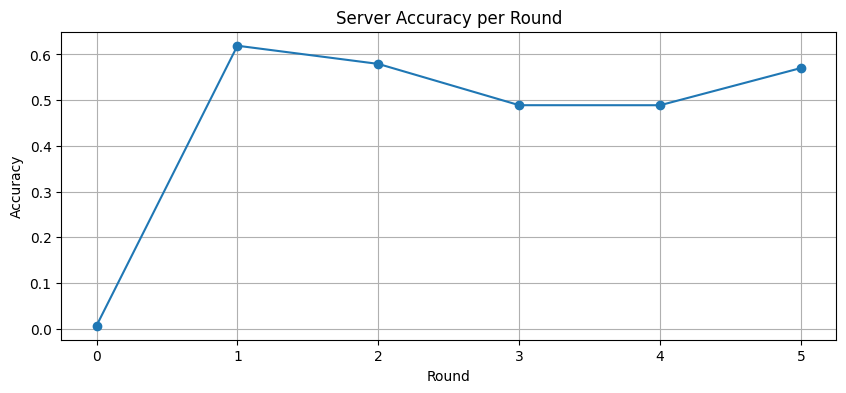

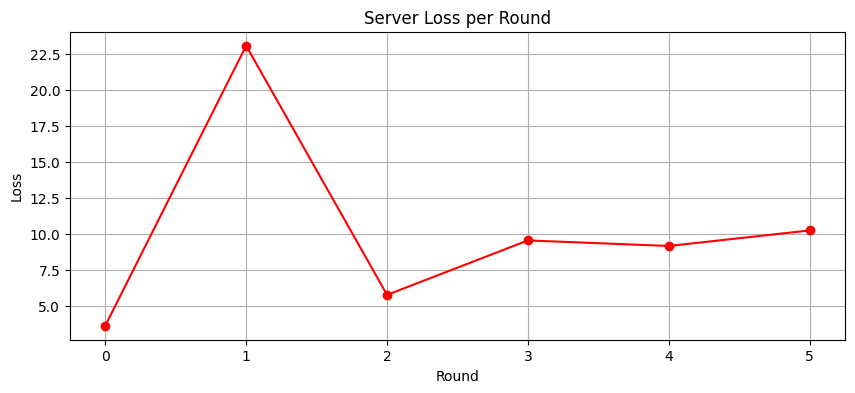

In [34]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOG START ---
print(f"{Colours.YELLOW.value}\nDeploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}\n")
print(f"Writing output to: {sub_dir_name}/{test_directory_name}\n{Colours.NORMAL.value}")

# Ghi thông tin ban đầu vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - Deploy simulation... Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Number of Clients = {NUM_OF_CLIENTS}\n")
    f.write(f"{datetime.datetime.now()} - Original train_df size: {train_df_shape}\n")

    for i in range(len(fl_X_train)):
        f.write(f"{datetime.datetime.now()} - {i}: X Shape {fl_X_train[i].shape}, Y Shape {fl_y_train[i].shape}\n")

    f.write(f"{datetime.datetime.now()} - X_test size: {X_test.shape}\n")
    f.write(f"{datetime.datetime.now()} - y_test size: {y_test.shape}\n")

# --- START SIMULATION ---
start_time = datetime.datetime.now()

ray_init_args = {"num_cpus": 2}

server_accuracy_history = []
server_loss_history = []

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_OF_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_OF_ROUNDS),
    strategy=strategy,
    client_resources={"num_cpus": 1},
    ray_init_args=ray_init_args,
)

end_time = datetime.datetime.now()
print("Total time taken: ", end_time - start_time)

# --- LOG END ---
print(f"{Colours.YELLOW.value}SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier")
print(f"Number of Clients = {NUM_OF_CLIENTS}{Colours.NORMAL.value}\n")

# Ghi thông tin kết thúc vào file
with open(f"Output/{sub_dir_name}/{test_directory_name}/Run_details.txt", "a") as f:
    f.write(f"{datetime.datetime.now()} - SIMULATION COMPLETE. Method = {METHOD} - {class_size_map[num_unique_classes]} ({class_size}) Classifier\n")
    f.write(f"{datetime.datetime.now()} - Total time taken: {end_time - start_time}\n")

# --- PLOT ACCURACY ---
plt.figure(figsize=(10, 4))
plt.plot(server_accuracy_history, marker='o')
plt.title('Server Accuracy per Round')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_accuracy_per_round.png")
plt.show()

# --- PLOT LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(server_loss_history, marker='o', color='red')
plt.title('Server Loss per Round')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig(f"Output/{sub_dir_name}/{test_directory_name}/server_loss_per_round.png")
plt.show()


	•	Accuracy “ảo” tăng dần, nhưng loss cho thấy mô hình không học ổn định.
	•	Đây là dấu hiệu điển hình của gradient/model poisoning:
	•	Các client độc hại đã làm sai lệch quá trình tổng hợp → mô hình toàn cục ra dự đoán “đúng nhãn” ở mức vừa đủ để giữ accuracy, nhưng phân phối xác suất (softmax) bị vỡ → loss bùng nổ.
	•	Nếu dùng mô hình này trong thực tế, khả năng phân loại sẽ rất không đáng tin cậy, dễ bị trigger backdoor hoặc gây lỗi khi gặp dữ liệu mới.

```
2025-09-10 08:21:45.818754 - 0 : Server evaluation complete - Accuracy: 0.0684, Loss: 3.6024
2025-09-10 08:39:35.686497 - 1 : Server evaluation complete - Accuracy: 0.5371, Loss: 55.9237
2025-09-10 08:43:03.436018 - 2 : Server evaluation complete - Accuracy: 0.5148, Loss: 392.7422
2025-09-10 08:46:40.682414 - 3 : Server evaluation complete - Accuracy: 0.5464, Loss: 437.0364
2025-09-10 08:49:46.192006 - 4 : Server evaluation complete - Accuracy: 0.5913, Loss: 167.1029
2025-09-10 08:52:52.581382 - 5 : Server evaluation complete - Accuracy: 0.6032, Loss: 99.2315


```

